# *n2i*: analysis

### TOC:
* [Demo](#Demo)
* [Analysis](#Analysis)
* [Grid search](#Grid search)

## Demo

n2i can be used both in command line and Jupyter notebook. The following code runs n2i with the default parameters.

NB: REMEBER TO DEFINE IF THE GRAPH IS DIRECTED AND/OR WEIGHTED

In [1]:
import pathlib
import numpy as np
import pandas as pd
import networkx as nx
from scipy.spatial import distance
from n2i.__main__ import n2i_main, n2i_nx_graph
from n2i.node2vec import read_graph

In [2]:
graph_path = '../data/graph/lesmiserables/lesmiserables_edgelist.txt'

graph = read_graph(weighted=False, 
               graph=graph_path,
               directed=False)

In [3]:
emb = n2i_nx_graph(nx_graph=graph, topics=3)

## Analysis

In [4]:
# similarity between connected nodes
def sim_in(G):
    sims = []
    for i in G.nodes:
        for j in list(G.neighbors(i)):
            sims.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims)

def select_notedge(G):
    v1 = np.random.choice(G.nodes())
    v2 = np.random.choice(G.nodes())

    while (v1,v2) in G.edges or v1==v2:
        v1 = np.random.choice(G.nodes())
        v2 = np.random.choice(G.nodes())
    return v1, v2
#     n = nx.number_of_nodes(G)
#     while True:
#         a, b = np.random.randint(0, n, size=2)
#         if (a, b) not in G.edges:
#             return a, b

# similarity between disconnected nodes
def sim_out(G, samples):
    sims_out = []
    for c in range(samples):
        i, j = select_notedge(G)
        sims_out.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims_out)

def homophily(G):
    return sim_in(G) / sim_out(G, 10000)

In [5]:
# graph_path = '../WoMG/data/graph/lesmiserables/lesmiserables_edgelist.txt'

# graph = read_graph(weighted=False, 
#                graph=graph_path,
#                directed=False)

# emb = n2i_nx_graph(nx_graph=graph, topics=3)
for i in graph.nodes:
    graph.node[i]['interests'] = emb[i]

si = sim_in(graph)
so = sim_out(graph, 5000)
print ("In similarity: {:.4f} \nOut similarity: {:.4f} \nHomophily rate: {:.4f}".format(si, so, si/so))

In similarity: 0.9543 
Out similarity: 0.6895 
Homophily rate: 1.3839


## Grid search

In [7]:
graph = '../data/graph/lesmiserables/lesmiserables_edgelist.txt'
G = read_graph(weighted=False, 
               graph=graph,
               directed=False)
p_val = [0.25, 0.5, 0.75, 1.25, 1.5, 1.75, 2]
q_val = [0.25, 0.5, 0.75, 1.25, 1.5, 1.75, 2]

topics=[15]
dimensions=[128]
walk_length=[80]
num_walks=[10]
window_size=[10]
iiter=[1]

In [8]:
stat = []

In [9]:
args_list = []

nr_experiments = 20

for t in topics:
    for d in dimensions:
        for wk in walk_length:
            for n in num_walks:
                for wi in window_size:
                    for ii in iiter:
                        for p in p_val:
                            for q in q_val:
                                for seed in range(nr_experiments):
                                    args = [t, d, wk, n, wi, ii, p, q, seed]
                                    args_list.append(args)

In [10]:
def run_experiment(*args):
    t, d, wk, n, wi, ii, p, q, seed = args
    G_emb = n2i_nx_graph(nx_graph=G, topics=t, 
             dimensions=d, walk_length=wk,
             num_walks=n, window_size=wi,
             iiter=ii, p=p, q=q,
             seed=seed+int(1000*(q+p)))
    for i in G.nodes:
        G.node[i]['interests'] = G_emb[i]
    si = sim_in(G)
    so = sim_out(G, 5000)
    return args + (si/so,)

In [11]:
run_experiment(*args_list[0])

(15, 128, 80, 10, 10, 1, 0.25, 0.25, 0, 1.4295368459175395)

In [14]:
result = list(map(lambda x: run_experiment(*x), args_list))

In [15]:
df = pd.DataFrame(result, columns=['t', 'd', 'wk', 'n', 'wi', 'ii', 'p', 'q', 'seed', 'hom'])
df.head()

,t,d,wk,n,wi,ii,p,q,seed,hom
0,15,128,80,10,10,1,0.25,0.25,0,1.423616
1,15,128,80,10,10,1,0.25,0.25,1,1.420262
2,15,128,80,10,10,1,0.25,0.25,2,1.459253
3,15,128,80,10,10,1,0.25,0.25,3,1.505689
4,15,128,80,10,10,1,0.25,0.25,4,1.406731


In [16]:
df2 = df.groupby(['p', 'q'])['hom'].mean().unstack()

In [17]:
%pylab inline

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


/Users/panisson/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5,1,'Homophily (mean of 20 realizations)')

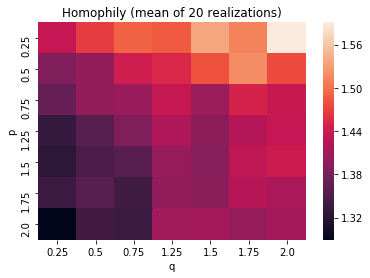

In [18]:
sns.heatmap(df2)
plt.title('Homophily (mean of 20 realizations)')

In [19]:
df.hom.min(), df.hom.max()

(0.9529761113468144, 1.7639085604307385)